In [ ]:
import json
import pandas as pd
import cv2
import numpy as np
from enum import Enum, auto
import sys
import torch
import matplotlib.pyplot as plt


sys.path.append("../Skin_segmentation")
sys.path.append('../../Models')

from Skindetector import *
from rPPGNet import rPPGNet

with open('../../Data/json_structure') as json_file:
    data = json.load(json_file)

def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 
            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list


root_dir = "/work3/s174159/data/"
video_file = root_dir + "00/02/c920-1.avi"
bb_file = root_dir + "bbox/00/02/c920-1.face"
ecg_path = root_dir + "00/02/viatom-raw.csv"
index_path = root_dir + "00/02/c920.csv"

bb_data =  pd.read_csv(bb_file, sep=" ", header=None, names=["frame", "x", "y", "w", "h"]).drop("frame", axis=1)
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
ecg = pd.read_csv()

In [125]:
model = rPPGNet()
model.load_state_dict(torch.load("../../logs/Eulerian/models/run_2023-10-30_11-34-54/model.pth", map_location=torch.device('cpu')))
model.eval()

rPPGNet(
  (ConvSpa1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSpa3): Sequential(
    (0): SpatioTemporalConv(
      (spatial_conv): Conv3d(16, 57, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn): BatchNorm3d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (temporal_conv): Conv3d(57, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
    )
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSpa4): Sequential(
    (0): SpatioTemporalConv(
      (spatial_conv): Conv3d(32, 72, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn): BatchNorm3d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      

In [126]:
import cv2
from IPython.display import display, Image

# Define the VideoCapture object and VideoWriter
output_file = 'output_video.mp4'
video = cv2.VideoCapture(video_file)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
out = cv2.VideoWriter(output_file, fourcc, 30, (128, 128) ) # 30 is the frames per second, (128, 128) is the frame size

display_handle = display(None, display_id=True)
i = 0

bounded_frames = []

try:
    while True:
        ret, frame = video.read()
        if not ret:  # Check if there are no more frames
            print("Finished video...")
            break  # Exit the loop if there are no more frames
        
        if i == len(data):
            i = 0
        x, y, w, h = bb_data.iloc[i].values.astype(int)
        i += 1
        frame_bb = frame[y:y + h, x:x + w]
        frame_bb = cv2.resize(frame_bb, (128, 128), interpolation=cv2.INTER_AREA)
        bounded_frames.append(np.array(frame_bb, dtype='float32'))
        #detector = SkinDetector(frame_bb)
        #detector.find_skin()
        #image, mask, skin = detector.get_resulting_images()
        
        # Save the processed frame to the output video
        #out.write(frame)
        
        #_, frame = cv2.imencode('.jpeg', frame)
        #display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    out.release()  # Release the VideoWriter
    display_handle.update(None)


None

Finished video...


In [127]:
frame_tensor = torch.tensor(np.array(bounded_frames[1:65]))
frame_tensor = torch.swapaxes(frame_tensor, 0, 3)
frame_tensor = torch.swapaxes(frame_tensor, 1, 3)

In [133]:
frame_tensor.unsqueeze(0).shape

torch.Size([1, 3, 64, 128, 128])

In [135]:
skin_map, rPPG_aux, rPPG, rPPG_SA1, rPPG_SA2, rPPG_SA3, rPPG_SA4, x_visual6464, x_visual3232 = model(frame_tensor.unsqueeze(0))

In [19]:
def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 

            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list

In [22]:
ecg
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
idx

,timestamp,idx_sig
0,1523631753577,4955
1,1523631753620,4960
2,1523631753643,4965
3,1523631753676,4970
4,1523631753707,4975
...,...,...
1795,1523631813486,12445
1796,1523631813513,12450
1797,1523631813560,12455
1798,1523631813582,12460


In [23]:
from ecgdetectors import Detectors
fs=250
detectors = Detectors(fs)
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg = ecg.iloc[int(idx.iloc[1].idx_sig/5):][:65*2] 
#r_peaks = detectors.two_average_detector(ecg[" ECG"])

IndexError: index 130 is out of bounds for axis 0 with size 130

In [17]:
r_peaks

[82, 329, 509, 811, 1639]

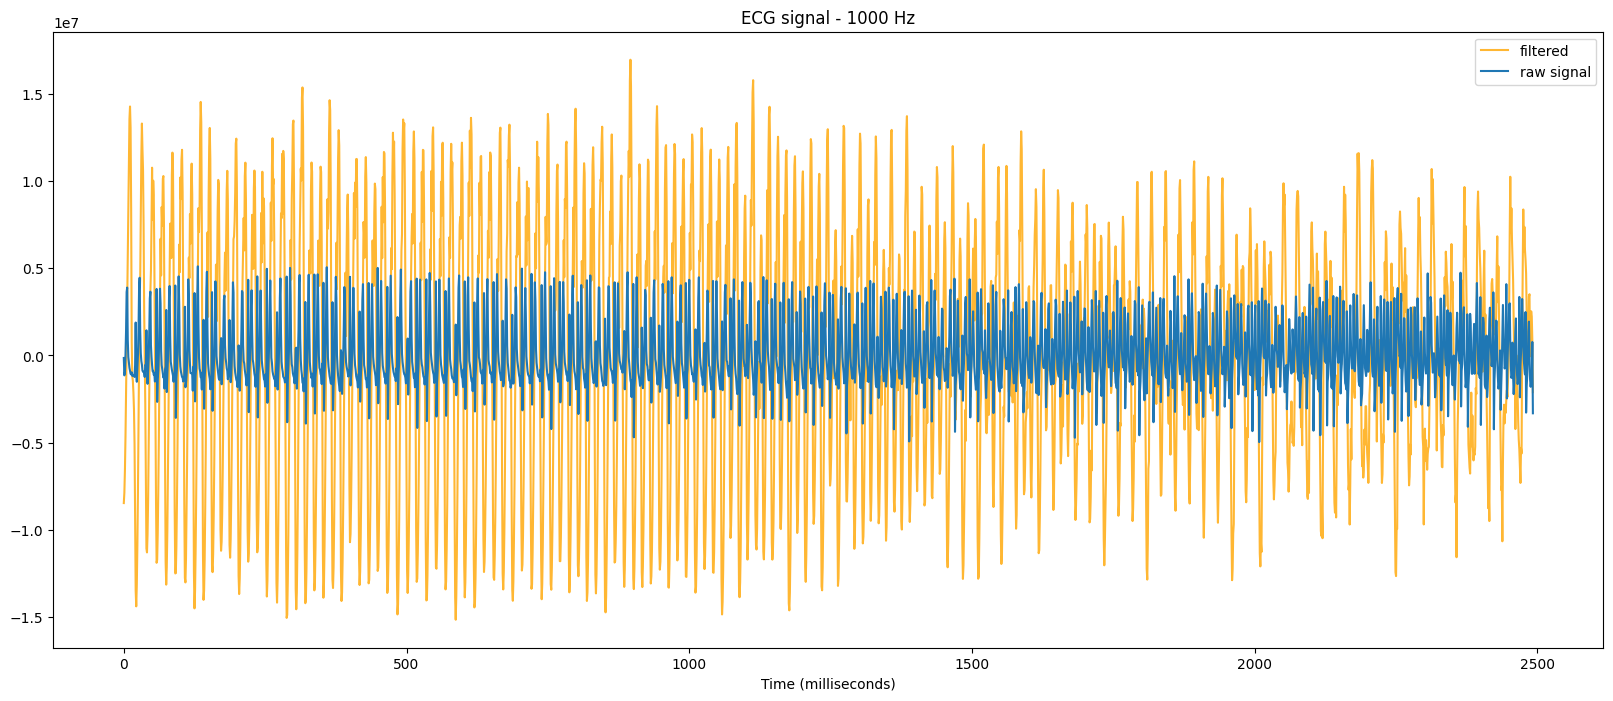

In [ ]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg_transformed = np.correlate(ecg[" ECG"], peak_filter, mode="same")
plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed, alpha = 0.8, c='orange')
plt.plot(ecg[" ECG"], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

In [ ]:
ecg = pd.read_csv(ecg_path)
#ecg

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,ECG_norm,ECG_MV
992,1523629969838,144179.2,-109.0,-56.0,-1.0,-1.0,0.0,0.622159,0.599432
993,1523629969862,-3119513.6,-109.0,-56.0,-1.0,-1.0,0.0,0.268466,0.555682
994,1523629969902,65536.0,-109.0,-56.0,-1.0,-1.0,0.0,0.613636,0.564489
995,1523629969943,747110.4,-108.0,-56.0,-1.0,-1.0,0.0,0.687500,0.568182
996,1523629969982,196608.0,-108.0,-56.0,-1.0,-1.0,0.0,0.627841,0.563920
...,...,...,...,...,...,...,...,...,...
1117,1523629974824,-1743257.6,-105.0,-56.0,-1.0,-1.0,0.0,0.417614,0.590057
1118,1523629974864,13107.2,-105.0,-56.0,-1.0,-1.0,0.0,0.607955,0.565909
1119,1523629974904,707788.8,-105.0,-56.0,-1.0,-1.0,0.0,0.683239,0.584375
1120,1523629974957,550502.4,-105.0,-56.0,-1.0,-1.0,0.0,0.666193,0.600852


In [21]:
idx

,1523631753577,4955
0,1523631753620,4960
1,1523631753643,4965
2,1523631753676,4970
3,1523631753707,4975
4,1523631753753,4980
...,...,...
1794,1523631813486,12445
1795,1523631813513,12450
1796,1523631813560,12455
1797,1523631813582,12460


In [ ]:
import scipy


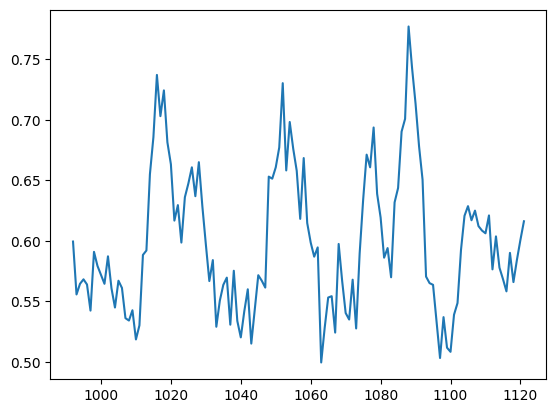

In [27]:
ecg = pd.read_csv(ecg_path)
#ecg[" ECG"] = detrend_ecg(ecg[" ECG"], 100)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
#ecg["ECG_norm"] = (ecg[" ECG"] - ecg[" ECG"].mean()) / ecg[" ECG"].std()
ecg["ECG_norm"] = (ecg[" ECG"] - np.min(ecg[" ECG"] )) / (np.max(ecg[" ECG"] ) - np.min(ecg[" ECG"] ))
ecg["ECG_MV"] = moving_average(ecg["ECG_norm"], 5)
ecg = ecg.iloc[int(idx.iloc[1].idx_sig/5):][:65*2] 
#plt.plot(ecg[" ECG"])
#plt.plot(ecg["ECG_norm"])
plt.plot(ecg["ECG_MV"])

In [207]:
ecg

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,ECG_norm,ECG_MV
243,1523629854047,812646.4,88.0,-56.0,-1.0,-1.0,0.0,0.835539,0.823062
244,1523629854087,825753.6,88.0,-56.0,-1.0,-1.0,0.0,0.837429,0.824575
245,1523629854127,-4417126.4,88.0,-56.0,-1.0,-1.0,0.0,0.081285,0.675992
246,1523629854167,1507328.0,88.0,-56.0,-1.0,-1.0,0.0,0.935728,0.699433
247,1523629854207,589824.0,88.0,-56.0,-1.0,-1.0,0.0,0.803403,0.698677
...,...,...,...,...,...,...,...,...,...
303,1523629856447,-2306867.2,88.0,-56.0,-1.0,-1.0,0.0,0.385633,0.652930
304,1523629856487,-1048576.0,88.0,-56.0,-1.0,-1.0,0.0,0.567108,0.586767
305,1523629856527,301465.6,88.0,-56.0,-1.0,-1.0,0.0,0.761815,0.589036
306,1523629856568,511180.8,88.0,-56.0,-1.0,-1.0,0.0,0.792060,0.609074


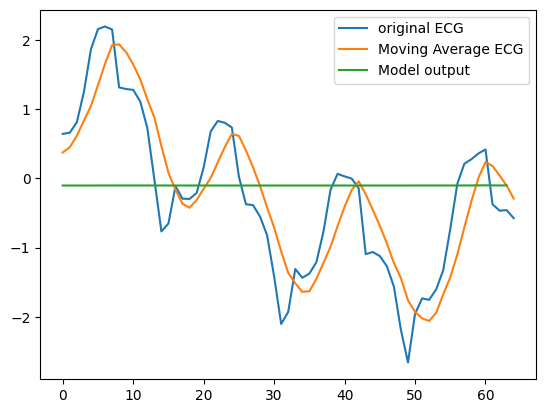

In [166]:
import matplotlib.pyplot as plt
ecg_path = root_dir + "00/01/viatom-raw.csv"
index_path = root_dir + "00/01/c920.csv"

def detrend_ecg(ecg_signal, smoothing_parameter=300):
    return np.convolve(ecg_signal, np.ones(smoothing_parameter) / smoothing_parameter, mode='same')

idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
ecg = pd.read_csv(ecg_path)
ecg[" ECG"] = detrend_ecg(ecg[" ECG"], 300)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
 #detrend the signal
ecg["ECG_norm"] = (ecg[" ECG"] - ecg[" ECG"].mean()) / ecg[" ECG"].std() 
ecg["ECG_MV"] = moving_average(ecg["ECG_norm"], 5)
ecg = ecg.iloc[int(idx.iloc[1].idx_sig/5):][:65] 
ecg
plt.plot(ecg["ECG_norm"].reset_index(drop=True), label='original ECG')
plt.plot(ecg["ECG_MV"].reset_index(drop=True),label='Moving Average ECG')
plt.plot(list(rPPG.detach().numpy()[0].T), label='Model output')
plt.legend()

In [158]:
ecg["ECG_norm"].reset_index(drop=True)

0    -0.164874
1    -0.505534
2    -0.639126
3    -0.953067
4    -1.226930
        ...   
60    2.233075
61    0.449624
62    0.169081
63    0.149042
64    0.162401
Name: ECG_norm, Length: 65, dtype: float64

In [67]:
from numpy import *
from numpy.linalg import *
A = (tril(ones((64,64)),-1) - tril(ones((64,64)),-6))/5.
A = A[5:,:]
pA = pinv(A) #pseudo inverse

In [37]:
skin_map, rPPG_aux, rPPG, rPPG_SA1, rPPG_SA2, rPPG_SA3, rPPG_SA4, x_visual6464, x_visual3232  = model(frame_tensor.unsqueeze(0))

In [74]:
rPPG
x2 = dot(pA,rPPG.squeeze(0).detach().numpy())

ValueError: shapes (64,59) and (64,) not aligned: 59 (dim 1) != 64 (dim 0)

In [73]:
rPPG.squeeze(0).detach().numpy()

array([-0.13569126, -0.13622795, -0.13560002, -0.1358516 , -0.13597304,
       -0.13608263, -0.13611983, -0.13614082, -0.13617523, -0.13620903,
       -0.13624398, -0.13628796, -0.13630407, -0.13632277, -0.13636677,
       -0.13655014, -0.13689977, -0.13737975, -0.13777523, -0.13799119,
       -0.13812818, -0.13815191, -0.13813885, -0.13812348, -0.1381072 ,
       -0.13810304, -0.13808823, -0.13804924, -0.13799398, -0.13789389,
       -0.1377715 , -0.13768291, -0.13776965, -0.13803524, -0.13842858,
       -0.13876674, -0.13895439, -0.13902862, -0.1389545 , -0.13882053,
       -0.13867883, -0.13854562, -0.1384258 , -0.1382946 , -0.1381386 ,
       -0.1379625 , -0.13773733, -0.13749054, -0.13725898, -0.13718598,
       -0.13729036, -0.1375239 , -0.13770626, -0.1377337 , -0.13767914,
       -0.13749386, -0.13724747, -0.1369373 , -0.13661064, -0.13628623,
       -0.13603346, -0.1355704 , -0.13486184, -0.13409175], dtype=float32)

In [ ]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *

pA = pinv(A) #pseudo inverse

# get x
x = random.randn(2000) + 5

# reconstruct
x2 = dot(pA,y)

plot(x,label='original x')
plot(y,label='averaged x')
plot(x2,label='reconstructed x')
legend()
show()